# Test Vectors Generation
- FP16 test vectors.
1. Adder:
    - Two addends and sum
    - a and b are inputs
    - y is output
2. Reconfigurable Accumulator:
    - Streams of data for 16 channels

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Number of decimal digits to print
n_fp = 8

## 1. Methods

### 1.1 Generate Binary Data
- Binary representation of FP16.
- `.view('H')` --> it changes the representation to 16-bit unsigned integer.
- `[2:]` --> ommit `0b` from the result.
- `zfill()` --> returns a copy of the string with 0 filled to the left. 

In [2]:
print(bin(np.float16(-0.4375).view('H')))
print(np.dtype('H'))

0b1011011100000000
uint16


In [3]:
# code from https://stackoverflow.com/questions/33451800/decimal-to-binary-half-precision-ieee-754-in-python
aux1 = bin(np.float16(0.0625).view('H'))[2:].zfill(16)
print(aux1)
print(type(aux1))

0010110000000000
<class 'str'>


In [3]:
"""
Method to obtain the FP16 binary representation of any FP number

IN:
n_fp <-- floating-point number

OUT:
b_fp16 --> FP16 binary representation (string)
"""
def to_FP16_bin(n_fp):
    # H is used to get a 16-bit unsigned integer representation
    return bin(np.float16(n_fp).view('H'))[2:].zfill(16)

In [3]:
# Example
a = 0.5
a_b = to_FP16_bin(a)
print(a_b)

b = -0.4375
b_b = to_FP16_bin(b)
print(b_b)

c = a + b
c_b = to_FP16_bin(c)
print(c_b)

print(f'Addition: {a} + {b} = {c}')

0011100000000000
1011011100000000
0010110000000000
Addition: 0.5 + -0.4375 = 0.0625


In [6]:
"""
This method cannot use broadcast --> revise it later
"""

# Example with an array
a = np.array([0.5, 0.5])
a_b = to_FP16_bin(a)
print(a_b)

b = np.array([-0.4375, -0.4375])
b_b = to_FP16_bin(b)
print(b_b)

c = a + b
c_b = to_FP16_bin(c)
print(c_b)

print(f'Addition: {a} + {b} = {c}')

TypeError: only integer scalar arrays can be converted to a scalar index

### 1.2 Generate Pseudorandom Numbers

In [4]:
"""
Method to generate a FP random number in a defined interval for testing

IN:
low_l <-- lower limit
up_l <-- upper limit
n_sample <-- number of samples to generate

OUT:
prn --> vector of pseudorandom numbers
"""
def prng_t(low_l, up_l, n_sample=1):
    # Individual samples are just float numbers no arrays
    if n_sample == 1:
        prn = np.random.random_sample()
    else:
        prn = np.random.random_sample((n_sample,))

    return (up_l - low_l) * prn + low_l

### 1.3 Convert Hex to fp16 numbers
- From Hex to Binary.
- Binary elements are separeted into sign, exponent, and mantissa.
- fp16 formula (normal numbers) is applied:
$$(-1)^{sign bit} \times 2^{exponent - 15} \times \left( 1 + \frac{mantissa}{1024} \right)$$

In [5]:
"""
Convert Hex string to decimal numbers in fp16 representation
- Only works for normal numbers

IN:
hex_s <-- hexadecimal string representing a fp16 number

OUT:
fp16_n --> fp16 decimal number
"""
def hex_to_fp16(hex_s):
    # Hex string --> INT16 --> INT16 to binary string
    bin_s = bin(int(hex_s, 16))
    # Drop the '0b'
    # Complete the 16 bits
    bin_s = bin_s[2:].zfill(16)

    # Debug
    # print(bin_s)
    # print(type(bin_s))
    # print(len(bin_s))

    # Separate sign, exponent, and mantissa.
    # Get their numerical representation
    # Turn the number into fp16 to make sure that the reconstructed number will be fp16

    # 1 bit for sign
    sign_t = bin_s[0]
    # print(f'Sign in bits: {sign_t}')
    sign_t = int(sign_t, 2)
    sign_t = np.float16(sign_t)
    # print(f'Sign value is {sign_t} and type is {sign_t.dtype}\n')

    # 5 bits for exponent
    exp_t = bin_s[1:6]
    # print(f'Exponent in bits: {exp_t}')
    exp_t = int(exp_t, 2)
    exp_t = np.float16(exp_t)
    # print(f'Exponent value is {exp_t} and type is {exp_t.dtype}\n')

    # 10 bits for mantissa
    man_t = bin_s[6:]
    # print(f'Mantissa in bits: {man_t}')
    man_t = int(man_t, 2)
    man_t = np.float16(man_t)
    # print(f'Mantissa value is {man_t} and type is {man_t.dtype}\n')

    # Apply the formula to calculate fp16 number
    number_t = ((np.float16(-1))**sign_t) * (np.float16(2)**(exp_t - np.float16(15))) * (np.float16(1) + (man_t/np.float16(1024)))
    # print(f'fp16 Decimal number: {number_t}')
    # print(f'and type is {number_t.dtype}') 
    return number_t

## 2. fp16 Adder

### 2.1 Test Vectors Generation
- Exceptions: --> 24 operations  
    - NaN --> 5 operations
        1. a is NaN (2)
        2. b is NaN (2)
        3. a and b are infinite: inf - inf 
    - Overflow --> 6 operations
        1. a is inf (2)
        2. b is inf (2)
        3. y is inf (2) --> > +- 65 504
    - Underflow --> 8 operations
        1. a is denormalized (2)
        2. b is denormalized (2)
        3. y is denormalized (2) --> < 0.000061
        4. y is zero (2)
    - Zero Input --> 5 operations
        1. a is zero (2)
        2. b is zero (2)
        3. a and b are zero (1)
- Normal Operations: 1.000 operations

In [88]:
# List to store input a and b 
# a consecutive pair corresponds to one operation
in_v = []

# List to store the expected output for y
# each element corresponds to one pair (a,b)
out_v = []

# List to store each operation in decimal representation
op_v = []

# Define the interval for the random number in the test
# Based on the normal numbers for FP16
low_l = -65000
up_l = 65000

#### 2.1.1 NaN Exceptions:
- We modify the NaN definition on the RTL code to match python definition: `16'b0111_1110_0000_0000`.

In [93]:
# For NaN Exceptions
in_v_nan = []
out_v_nan = []
op_v_nan = []

In [94]:
# a is NaN
ops = 2
seeds = np.array([191, 194])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends
    a = np.nan
    in_v_nan.append(to_FP16_bin(a))
    b = prng_t(low_l=low_l, up_l=up_l)
    in_v_nan.append(to_FP16_bin(b))

    # Sum
    y = a + b
    out_v_nan.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a} + {b:.{n_fp}f} = {y}'
    op_v_nan.append(op_sum)

print(in_v_nan)
print(out_v_nan)
print(op_v_nan)


['0111111000000000', '0110110101001000', '0111111000000000', '0111101101101100']
['0111111000000000', '0111111000000000']
['nan + 5409.26726588 = nan', 'nan + 60800.80630733 = nan']


In [95]:
# b is NaN
ops = 2
seeds = np.array([1, 3])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends
    a = prng_t(low_l=low_l, up_l=up_l)
    in_v_nan.append(to_FP16_bin(a))
    b = np.nan
    in_v_nan.append(to_FP16_bin(b))

    # Sum
    y = a + b
    out_v_nan.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a:.{n_fp}f} + {b} = {y}'
    op_v_nan.append(op_sum)

print(in_v_nan)
print(out_v_nan)
print(op_v_nan)

['0111111000000000', '0110110101001000', '0111111000000000', '0111101101101100', '1111000101000100', '0111111000000000', '0110111001110011', '0111111000000000']
['0111111000000000', '0111111000000000', '0111111000000000', '0111111000000000']
['nan + 5409.26726588 = nan', 'nan + 60800.80630733 = nan', '-10787.13938867 + nan = nan', '6603.72733469 + nan = nan']


In [96]:
# a and b are inf

# Addends
a = np.inf
in_v_nan.append(to_FP16_bin(a))
b = -np.inf
in_v_nan.append(to_FP16_bin(b))

# Sum
y = np.nan
out_v_nan.append(to_FP16_bin(y))

# Operation in base 10
op_sum = f'{a} + {b} = {y}'
op_v_nan.append(op_sum)

print(in_v_nan)
print(out_v_nan)
print(op_v_nan)
    

['0111111000000000', '0110110101001000', '0111111000000000', '0111101101101100', '1111000101000100', '0111111000000000', '0110111001110011', '0111111000000000', '0111110000000000', '1111110000000000']
['0111111000000000', '0111111000000000', '0111111000000000', '0111111000000000', '0111111000000000']
['nan + 5409.26726588 = nan', 'nan + 60800.80630733 = nan', '-10787.13938867 + nan = nan', '6603.72733469 + nan = nan', 'inf + -inf = nan']


#### 2.1.2 Overflow Exceptions:

In [97]:
# For Overflow Exceptions
in_v_ovf = []
out_v_ovf = []
op_v_ovf = []

In [98]:
# a is inf
ops = 2
seeds = np.array([7, 10])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends
    a = np.inf
    in_v_ovf.append(to_FP16_bin(a))
    b = prng_t(low_l=low_l, up_l=up_l)
    in_v_ovf.append(to_FP16_bin(b))

    # Sum
    y = a + b
    out_v_ovf.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a} + {b:.{n_fp}f} = {y}'
    op_v_ovf.append(op_sum)

print(in_v_ovf)
print(out_v_ovf)
print(op_v_ovf)

['0111110000000000', '1111101010111001', '0111110000000000', '0111100001001110']
['0111110000000000', '0111110000000000']
['inf + -55079.92238139 = inf', 'inf + 35271.68362468 = inf']


In [99]:
# b is inf
ops = 2
seeds = np.array([26, 87])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends
    a = prng_t(low_l=low_l, up_l=up_l)
    in_v_ovf.append(to_FP16_bin(a))
    b = np.inf
    in_v_ovf.append(to_FP16_bin(b))

    # Sum
    y = a + b
    out_v_ovf.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a:.{n_fp}f} + {b} = {y}'
    op_v_ovf.append(op_sum)

print(in_v_ovf)
print(out_v_ovf)
print(op_v_ovf)

['0111110000000000', '1111101010111001', '0111110000000000', '0111100001001110', '1111011000011001', '0111110000000000', '0111010011110110', '0111110000000000']
['0111110000000000', '0111110000000000', '0111110000000000', '0111110000000000']
['inf + -55079.92238139 = inf', 'inf + 35271.68362468 = inf', '-24968.45615875 + inf = inf', '20314.34408028 + inf = inf']


In [100]:
# y is inf
# sum > |65 504|
ops = 2
seeds = np.array([66, 55])
limit_l = np.array([40000, -50000])
limit_h = np.array([50000, -40000])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends
    a = prng_t(low_l=limit_l[op], up_l=limit_h[op])
    in_v_ovf.append(to_FP16_bin(a))
    b = prng_t(low_l=limit_l[op], up_l=limit_h[op])
    in_v_ovf.append(to_FP16_bin(b))

    # Sum
    y = a + b
    out_v_ovf.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a:.{n_fp}f} + {b:.{n_fp}f} = {np.float16(y)}'
    op_v_ovf.append(op_sum)

print(in_v_ovf)
print(out_v_ovf)
print(op_v_ovf)

['0111110000000000', '1111101010111001', '0111110000000000', '0111100001001110', '1111011000011001', '0111110000000000', '0111010011110110', '0111110000000000', '0111100100010010', '0111100100001100', '1111100111111101', '1111100011101011']
['0111110000000000', '0111110000000000', '0111110000000000', '0111110000000000', '0111110000000000', '1111110000000000']
['inf + -55079.92238139 = inf', 'inf + 35271.68362468 = inf', '-24968.45615875 + inf = inf', '20314.34408028 + inf = inf', '41542.87578131 + 41336.99560700 = inf', '-49068.91713328 + -40283.44080010 = -inf']


C:\Users\Andres\AppData\Local\Temp\ipykernel_21676\4047982706.py:12: RuntimeWarning: overflow encountered in cast
  return bin(np.float16(n_fp).view('H'))[2:].zfill(16)
C:\Users\Andres\AppData\Local\Temp\ipykernel_21676\2242942362.py:23: RuntimeWarning: overflow encountered in cast
  op_sum = f'{a:.{n_fp}f} + {b:.{n_fp}f} = {np.float16(y)}'


#### 2.1.3 Underflow Exceptions:

In [101]:
# For Underflow Exceptions
in_v_unf = []
out_v_unf = []
op_v_unf = []

In [102]:
# a is Denorm
ops = 2
seeds = np.array([742, 35])
limit_l = np.array([0, -0.000061])
limit_h = np.array([0.000061, 0])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends
    a = prng_t(low_l=limit_l[op], up_l=limit_h[op])
    in_v_unf.append(to_FP16_bin(a))
    b = prng_t(low_l=low_l, up_l=up_l)
    in_v_unf.append(to_FP16_bin(b))

    # Sum
    y = 0.
    out_v_unf.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a:.{n_fp}f} + {b:.{n_fp}f} = {y:.{n_fp}f}'
    op_v_unf.append(op_sum)

print(in_v_unf)
print(out_v_unf)
print(op_v_unf)

['0000000000000001', '1111100011100111', '1000001000101011', '1111011000010101']
['0000000000000000', '0000000000000000']
['0.00000008 + -40144.37816087 = 0.00000000', '-0.00003306 + -24914.55109456 = 0.00000000']


In [103]:
# b is Denorm
ops = 2
seeds = np.array([31, 47])
limit_l = np.array([0, -0.000061])
limit_h = np.array([0.000061, 0])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends
    a = prng_t(low_l=low_l, up_l=up_l)
    in_v_unf.append(to_FP16_bin(a))
    b = prng_t(low_l=limit_l[op], up_l=limit_h[op]) 
    in_v_unf.append(to_FP16_bin(b))

    # Sum
    y = 0.
    out_v_unf.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a:.{n_fp}f} + {b:.{n_fp}f} = {y:.{n_fp}f}'
    op_v_unf.append(op_sum)

print(in_v_unf)
print(out_v_unf)
print(op_v_unf)

['0000000000000001', '1111100011100111', '1000001000101011', '1111011000010101', '1111011011001010', '0000001111010101', '1111101000100010', '1000000000011010']
['0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000']
['0.00000008 + -40144.37816087 = 0.00000000', '-0.00003306 + -24914.55109456 = 0.00000000', '-27813.00318413 + 0.00005844 = 0.00000000', '-50246.49865383 + -0.00000156 = 0.00000000']


In [104]:
# y is Denorm
ops = 2
seeds = np.array([491, 179])
# To get a denorm. result
bias_f = np.array([0.00006, -0.000058])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends --> make sure that bias is the result
    # a - b = y
    # (-a + bias) + (a)
    # (a - bias) + (-a)
    a = prng_t(low_l=low_l, up_l=up_l)
    b = -a
    a =  a + bias_f[op]

    in_v_unf.append(to_FP16_bin(a))
    in_v_unf.append(to_FP16_bin(b))

    # Result without the underflow rule in the RTL
    y = a + b
    print(f'Verify the operations: {a:.{n_fp}f} + {b:.{n_fp}f} = {y:.{n_fp}f}')

    # Sum for the RTL testbench
    y = 0.
    out_v_unf.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a:.{n_fp}f} + {b:.{n_fp}f} = {y:.{n_fp}f}'
    op_v_unf.append(op_sum)

print(in_v_unf)
print(out_v_unf)
print(op_v_unf)

Verify the operations: -18249.57775831 + 18249.57781831 = 0.00006000
Verify the operations: 58559.15598598 + -58559.15604398 = -0.00005800
['0000000000000001', '1111100011100111', '1000001000101011', '1111011000010101', '1111011011001010', '0000001111010101', '1111101000100010', '1000000000011010', '1111010001110101', '0111010001110101', '0111101100100110', '1111101100100110']
['0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000']
['0.00000008 + -40144.37816087 = 0.00000000', '-0.00003306 + -24914.55109456 = 0.00000000', '-27813.00318413 + 0.00005844 = 0.00000000', '-50246.49865383 + -0.00000156 = 0.00000000', '-18249.57775831 + 18249.57781831 = 0.00000000', '58559.15598598 + -58559.15604398 = 0.00000000']


In [105]:
# y is zero
ops = 2
seeds = np.array([154, 16])

for op in range(ops):
    # For reproducibility
    np.random.seed(seed=seeds[op])
    
    # Addends 
    a = prng_t(low_l=low_l, up_l=up_l)
    b = -a

    in_v_unf.append(to_FP16_bin(a))
    in_v_unf.append(to_FP16_bin(b))

    # sum
    y = a + b
    out_v_unf.append(to_FP16_bin(y))

    # Operation in base 10
    op_sum = f'{a:.{n_fp}f} + {b:.{n_fp}f} = {y:.{n_fp}f}'
    op_v_unf.append(op_sum)

print(in_v_unf)
print(out_v_unf)
print(op_v_unf)

['0000000000000001', '1111100011100111', '1000001000101011', '1111011000010101', '1111011011001010', '0000001111010101', '1111101000100010', '1000000000011010', '1111010001110101', '0111010001110101', '0111101100100110', '1111101100100110', '0110001111011000', '1110001111011000', '1111100001100100', '0111100001100100']
['0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000', '0000000000000000']
['0.00000008 + -40144.37816087 = 0.00000000', '-0.00003306 + -24914.55109456 = 0.00000000', '-27813.00318413 + 0.00005844 = 0.00000000', '-50246.49865383 + -0.00000156 = 0.00000000', '-18249.57775831 + 18249.57781831 = 0.00000000', '58559.15598598 + -58559.15604398 = 0.00000000', '1004.08988774 + -1004.08988774 = 0.00000000', '-35972.15971004 + 35972.15971004 = 0.00000000']


#### 2.1.4 Zero Inputs Case:
- Since the exceptions check the exponent, zero inputs could be mistaken by an exception.
    - Change the definition of denormalized number from the original code.

In [106]:
# Reduced Interval to represent numbers with more fractional digits
low_l = -50
up_l = 50

# For Normal Numbers
in_v_zero = []
out_v_zero = []
op_v_zero = []

In [107]:
# a is zero
ops = 2
seed = 99

# For reproducibility
np.random.seed(seed=seed)

# Addends
b = prng_t(low_l=low_l, up_l=up_l, n_sample=ops)
# Transform to fp16
b = np.float16(b)
print(f'Dimension of b: {b.shape}')
print(f'Data Type of b: {b.dtype}')
print(b)

a = np.zeros(ops)
# Transform to fp16
a = np.float16(a)
print(f'Dimension of a: {a.shape}')
print(f'Data Type of a: {a.dtype}')
print(a)

# Generate the result and store (fp16)
y = a + b
print(f'Dimension of y: {y.shape}')
print(f'Data Type of y: {y.dtype}')
print(y)

# Store values
for op in range(ops):
    # Addends
    in_v_zero.append(to_FP16_bin(a[op]))
    in_v_zero.append(to_FP16_bin(b[op]))

    # Sum
    out_v_zero.append(to_FP16_bin(y[op]))

    # Operation in base 10
    op_sum = f'{a[op]:.{n_fp}f} + {b[op]:.{n_fp}f} = {y[op]:.{n_fp}f}'
    op_v_zero.append(op_sum)


print(f'Dimension of input vector: {len(in_v_zero)}')
print(in_v_zero)
print(f'Dimension of output vector: {len(out_v_zero)}')
print(out_v_zero)
print(f'Dimension of operation vector: {len(op_v_zero)}')
print(op_v_zero)


Dimension of b: (2,)
Data Type of b: float16
[17.23  -1.192]
Dimension of a: (2,)
Data Type of a: float16
[0. 0.]
Dimension of y: (2,)
Data Type of y: float16
[17.23  -1.192]
Dimension of input vector: 4
['0000000000000000', '0100110001001111', '0000000000000000', '1011110011000101']
Dimension of output vector: 2
['0100110001001111', '1011110011000101']
Dimension of operation vector: 2
['0.00000000 + 17.23437500 = 17.23437500', '0.00000000 + -1.19238281 = -1.19238281']


In [108]:
# b is zero
ops = 2
seed = 708

# For reproducibility
np.random.seed(seed=seed)

# Addends
a = prng_t(low_l=low_l, up_l=up_l, n_sample=ops) 
# Transform to fp16
a = np.float16(a)
print(f'Dimension of a: {a.shape}')
print(f'Data Type of a: {a.dtype}')
print(a)

b = np.zeros(ops) 
# Transform to fp16
b = np.float16(b)
print(f'Dimension of b: {b.shape}')
print(f'Data Type of b: {b.dtype}')
print(b)

# Generate the result and store (fp16)
y = a + b
print(f'Dimension of y: {y.shape}')
print(f'Data Type of y: {y.dtype}')
print(y)

# Store values
for op in range(ops):
    # Addends
    in_v_zero.append(to_FP16_bin(a[op]))
    in_v_zero.append(to_FP16_bin(b[op]))

    # Sum
    out_v_zero.append(to_FP16_bin(y[op]))

    # Operation in base 10
    op_sum = f'{a[op]:.{n_fp}f} + {b[op]:.{n_fp}f} = {y[op]:.{n_fp}f}'
    op_v_zero.append(op_sum)


print(f'Dimension of input vector: {len(in_v_zero)}')
print(in_v_zero)
print(f'Dimension of output vector: {len(out_v_zero)}')
print(out_v_zero)
print(f'Dimension of operation vector: {len(op_v_zero)}')
print(op_v_zero)

Dimension of a: (2,)
Data Type of a: float16
[-48.5  32.1]
Dimension of b: (2,)
Data Type of b: float16
[0. 0.]
Dimension of y: (2,)
Data Type of y: float16
[-48.5  32.1]
Dimension of input vector: 8
['0000000000000000', '0100110001001111', '0000000000000000', '1011110011000101', '1101001000010000', '0000000000000000', '0101000000000011', '0000000000000000']
Dimension of output vector: 4
['0100110001001111', '1011110011000101', '1101001000010000', '0101000000000011']
Dimension of operation vector: 4
['0.00000000 + 17.23437500 = 17.23437500', '0.00000000 + -1.19238281 = -1.19238281', '-48.50000000 + 0.00000000 = -48.50000000', '32.09375000 + 0.00000000 = 32.09375000']


In [109]:
# a and b are zero

# Addends
a = 0. 
# Transform to fp16
a = np.float16(a)

b = 0. 
# Transform to fp16
b = np.float16(b)

# Generate the result and store (fp16)
y = a + b

# Addends
in_v_zero.append(to_FP16_bin(a))
in_v_zero.append(to_FP16_bin(b))

# Sum
out_v_zero.append(to_FP16_bin(y))

# Operation in base 10
op_sum = f'{a:.{n_fp}f} + {b:.{n_fp}f} = {y:.{n_fp}f}'
op_v_zero.append(op_sum)

print(f'Dimension of input vector: {len(in_v_zero)}')
print(in_v_zero)
print(f'Dimension of output vector: {len(out_v_zero)}')
print(out_v_zero)
print(f'Dimension of operation vector: {len(op_v_zero)}')
print(op_v_zero)

Dimension of input vector: 10
['0000000000000000', '0100110001001111', '0000000000000000', '1011110011000101', '1101001000010000', '0000000000000000', '0101000000000011', '0000000000000000', '0000000000000000', '0000000000000000']
Dimension of output vector: 5
['0100110001001111', '1011110011000101', '1101001000010000', '0101000000000011', '0000000000000000']
Dimension of operation vector: 5
['0.00000000 + 17.23437500 = 17.23437500', '0.00000000 + -1.19238281 = -1.19238281', '-48.50000000 + 0.00000000 = -48.50000000', '32.09375000 + 0.00000000 = 32.09375000', '0.00000000 + 0.00000000 = 0.00000000']


#### 2.1.5 Normal Operations:
- For error analysis, we will store the addends and sums with different precision:
    - Addends --> correspond to the exact FP16 representation but they are extended to FP64 to obtain the exact result: `a_test` and `b_test`
    - Approx. sum --> sum is performed using FP16, so there is some approximation in the result: `y_approx_sw`
    - Exact sum --> sum is performed using FP64, so there is no approximation in the result: `y_exact_sw`

In [110]:
# Reduced Interval to avoid overflows
low_l = -50
up_l = 50

# For Normal Numbers
in_v_norm = []
out_v_norm = []
op_v_norm = []

In [111]:
# Normal operations
ops = 1000
seed = 22

# For reproducibility
np.random.seed(seed=seed)

# Total prn's for operations
total_n = prng_t(low_l=low_l, up_l=up_l, n_sample=2*ops)
# Numbers are truncated to fp16
total_n = np.float16(total_n)
# print(total_n[:10])
# print(total_n[ops:ops+10])
# print(total_n.shape)

# Addends
a = total_n[:ops]
print(f'Dimension of a: {a.shape}')
print(f'Data Type of a: {a.dtype}')
print(a[:10])

# a for error analysis
# make a shallow copy to get a new array independent of the original a
a_test = np.copy(a)
# Extend to fp64 to get the exact result
a_test = np.float64(a_test)

b = total_n[ops:]
print(f'Dimension of b: {b.shape}')
print(f'Data Type of b: {b.dtype}')
print(b[:10])

# b for error analysis
# make a shallow copy to get a new array independent of the original b
b_test = np.copy(b)
# Extend to fp64 to get the exact result
b_test = np.float64(b_test)

# Generate the result and store (fp16)
y = a + b
print(f'Dimension of y: {y.shape}')
print(f'Data Type of y: {y.dtype}')
print(y[:10])

# y for error analysis
# make a shallow copy to get a new array independent of the original y
y_approx_sw = np.copy(y)
# Extend to fp64 to operate with the exact result
y_approx_sw = np.float64(y_approx_sw)
# Calculate the exact y
y_exact_sw = a_test + b_test

# Store values
for op in range(ops):
    # Addends
    in_v_norm.append(to_FP16_bin(a[op]))
    in_v_norm.append(to_FP16_bin(b[op]))

    # Sum
    out_v_norm.append(to_FP16_bin(y[op]))

    # Operation in base 10
    op_sum = f'{a[op]:.{n_fp}f} + {b[op]:.{n_fp}f} = {y[op]:.{n_fp}f}'
    op_v_norm.append(op_sum)


print(f'Dimension of input vector: {len(in_v_norm)}')
print(in_v_norm[0:10])
print(f'Dimension of output vector: {len(out_v_norm)}')
print(out_v_norm[0:10])
print(f'Dimension of operation vector: {len(op_v_norm)}')
print(op_v_norm[0:10])


Dimension of a: (1000,)
Data Type of a: float16
[-29.16   -1.832  -7.945  35.9   -32.88  -16.11  -22.95   19.11  -27.95
  31.19 ]
Dimension of b: (1000,)
Data Type of b: float16
[  9.53 -22.39  18.17 -12.31 -21.9   23.95  47.22  31.8   20.84  41.44]
Dimension of y: (1000,)
Data Type of y: float16
[-19.62  -24.22   10.23   23.6   -54.78    7.844  24.27   50.9    -7.11
  72.6  ]
Dimension of input vector: 2000
['1100111101001010', '0100100011000100', '1011111101010100', '1100110110011001', '1100011111110010', '0100110010001011', '0101000001111101', '1100101000101000', '1101000000011100', '1100110101111010']
Dimension of output vector: 1000
['1100110011101000', '1100111000001110', '0100100100011101', '0100110111100110', '1101001011011001', '0100011111011000', '0100111000010001', '0101001001011101', '1100011100011100', '0101010010001010']
Dimension of operation vector: 1000
['-29.15625000 + 9.53125000 = -19.62500000', '-1.83203125 + -22.39062500 = -24.21875000', '-7.94531250 + 18.17187500 

#### 2.1.6 Total Operations:

In [112]:
# List to store input a and b 
# a consecutive pair corresponds to one operation
in_v = in_v_nan + in_v_ovf + in_v_unf + in_v_zero + in_v_norm
print(f'Total number of addends: {len(in_v)}')

# List to store the expected output for y
# each element corresponds to one pair (a,b)
out_v = out_v_nan + out_v_ovf + out_v_unf + out_v_zero + out_v_norm
print(f'Total number of sums: {len(out_v)}')

# List to store each operation in decimal representation
op_v = op_v_nan + op_v_ovf + op_v_unf + op_v_zero + op_v_norm
print(f'Total number of operations: {len(op_v)}')

Total number of addends: 2048
Total number of sums: 1024
Total number of operations: 1024


### 2.2 Text File Creation
- Create 3 text files:
    - test_vec.txt --> input vectors a and b are consecutive for one operation
    - label_vec.txt --> expected output y corresponding to a + b
    - op_summary.txt --> operands in base 10

In [113]:
# Input vector text file
df = pd.DataFrame(in_v)
display(df)

# Save to .txt file
df.to_csv("./test_vectors/test_vec.txt", header=None, index=None, sep=' ', mode='w')

,0
0,0111111000000000
1,0110110101001000
2,0111111000000000
3,0111101101101100
4,1111000101000100
...,...
2043,0101000001010110
2044,1100100001100001
2045,1100100111010101
2046,1100111010111100


In [114]:
# Output vector text file
df = pd.DataFrame(out_v)
display(df)

# Save to .txt file
df.to_csv("./test_vectors/label_vec.txt", header=None, index=None, sep=' ', mode='w')

,0
0,0111111000000000
1,0111111000000000
2,0111111000000000
3,0111111000000000
4,0111111000000000
...,...
1019,0101000101110000
1020,0011111011010000
1021,0101001010001011
1022,1100110100011011


In [115]:
# Operation vector text file
df = pd.DataFrame(op_v)
display(df)

# Save to .txt file
df.to_csv("./test_vectors/op_summary.txt", header=None, index=None, sep=' ', mode='w')

,0
0,nan + 5409.26726588 = nan
1,nan + 60800.80630733 = nan
2,-10787.13938867 + nan = nan
3,6603.72733469 + nan = nan
4,inf + -inf = nan
...,...
1019,18.84375000 + 24.67187500 = 43.50000000
1020,33.56250000 + -31.85937500 = 1.70312500
1021,17.65625000 + 34.68750000 = 52.34375000
1022,-8.75781250 + -11.66406250 = -20.42187500


### 2.3 Error Analysis
- Compare results from software (sw) and hardware (hw).
    - y_approx_sw is the result of using fp16 operations.
    - y_exact_sw is the result of using fp64 operations.
    - y_approx_hw is the result of using fp16 operations in hardware.

#### 2.3.1 Error in software:

In [116]:
# Addends a and b
# Its representation much what fp16 can represent
# but they are extended to fp64 to get an exact result
print(f'a: dimension {a_test.shape} and extended to {a_test.dtype}')
print(f'b: dimension {b_test.shape} and extended to {b_test.dtype}')

# Sums y
# Results obtained operating with fp16 (approx.) --> extended to fp64 for error calculation
# Results obtained operation with fp64 (exact)
print(f'y approx. in software: dimension {y_approx_sw.shape} and extended to {y_approx_sw.dtype}')
print(f'y exact result in software: dimension {y_exact_sw.shape} and extended to {y_exact_sw.dtype}')

a: dimension (1000,) and extended to float64
b: dimension (1000,) and extended to float64
y approx. in software: dimension (1000,) and extended to float64
y exact result in software: dimension (1000,) and extended to float64


In [117]:
# Absolute Error calculation
error_sw = np.abs(y_exact_sw - y_approx_sw)

Text(0, 0.5, '$|y_{exact} - y_{approx}|$')

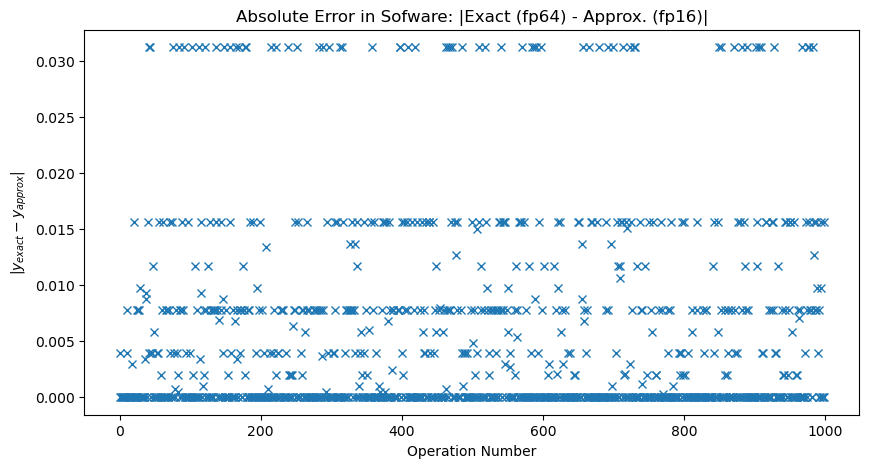

In [118]:
# Plot absolute error
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(error_sw, 'x')
plt.title("Absolute Error in Sofware: |Exact (fp64) - Approx. (fp16)|")
# plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Operation Number")
plt.ylabel("$|y_{exact} - y_{approx}|$")

In [119]:
# Number of operations with error
print(f'Number of operations with errors: {np.count_nonzero(error_sw)}/{ops}')

# Mean Absolute Error
print(f'Mean Absolute Error (MAE) in Sofware: {np.mean(error_sw, dtype=np.float64):.{n_fp}f}')

Number of operations with errors: 492/1000
Mean Absolute Error (MAE) in Sofware: 0.00560703


#### 2.3.2 Error in hardware:
- Some Python results differs from the RTL results: 261/1024
    - 2/24 --> Operations with exceptions
    - 259/1000 --> Normal Operations
- w.r.t the exceptions, when the sum of two numbers is greater than the max. number ($sum > |65 504|$) to represent in fp16, the hardware give NaN (mantissa != 0) since it cannot calculate exactly inf (mantissa == 0).
    - Those are the two first mistakes, so they are not considered in the analysis. 

In [120]:
# Load the hardware results
df = pd.read_csv("./RTL_results/fp16_hw_results.txt", header=None)
display(df)

,0
0,7e00
1,7e00
2,7e00
3,7e00
4,7e00
...,...
1019,5170
1020,3ed0
1021,528b
1022,cd1b


In [121]:
# Get the items in a list
result_l = df[0].astype(str).values.tolist()

# Drop the results from the exception cases
result_l = result_l[24:]
print(len(result_l))
print(result_l)

1000
['cce8', 'ce0e', '491d', '4de6', 'd2d9', '47d8', '4e11', '525d', 'c71c', '548a', 'd373', 'd0d4', '49a6', 'cd91', 'd501', 'ccd4', '453c', '51e9', '4628', '47e4', '5278', 'c930', '45d4', '3ed8', 'c4b1', '5166', '4fc0', 'cf4b', '4d1e', '51a4', '47b4', '44cc', 'ce41', 'c514', 'c87c', '5270', '4c03', 'd092', '50fb', 'bb2a', 'd072', 'd4e5', '4e1d', 'd589', 'c990', '4e22', '50fc', 'd19d', 'cb9c', 'cd26', 'd3f3', '4e99', '4dc2', 'c8f2', '3100', '4be5', 'd315', '4a78', 'd02e', '4dc2', '4ed2', 'd397', 'c664', 'cc76', '4ef5', '51ea', 'c926', 'd186', '54d9', 'd5f7', 'cd56', '5475', '50aa', 'd4ec', '5281', 'd529', '5142', 'cef4', 'c448', 'c0b5', '4c5c', '5082', 'bf97', 'cd1f', '5520', 'ccec', '4f2b', '4d58', '51b6', 'cc57', '4df7', '5567', '9e00', 'c678', '4e74', 'ccb0', 'c5ac', '5452', '4350', 'c804', 'ce58', '3da0', 'c97d', 'd47a', '50fb', '457e', 'c438', 'd15a', 'ccbb', '3600', 'cd71', 'd492', 'd52e', '53d9', '4dfd', '50ef', 'd3f9', '5365', 'c5b1', 'cb44', '524f', 'd497', '4544', 'd34a', 'c

In [122]:
# Get the fp16 representation of each result
for i, hex_s in enumerate(result_l):
    if (i == 0):
        # In the 1st iteration, we create the array
        # with the fp16 representation
        y_approx_hw = hex_to_fp16(hex_s=hex_s)
    elif (i == 1):
        # fp16 representation
        y_result = hex_to_fp16(hex_s=hex_s)
        # Second interation, we concatenate two numbers
        y_approx_hw = np.concatenate(([y_approx_hw],[y_result]), axis=0)

    else:
        # fp16 representation
        y_result = hex_to_fp16(hex_s=hex_s)
        # For the rest, we just concatenate the results
        y_approx_hw = np.concatenate((y_approx_hw,[y_result]), axis=0)

# Extend to fp64 for error calculation
y_approx_hw = np.float64(y_approx_hw)

# Debug
print(f'y approx. in hardware: dimension {y_approx_hw.shape} and extended to {y_approx_hw.dtype}')

y approx. in hardware: dimension (1000,) and extended to float64


In [123]:
# Absolute Error calculation
# w.r.t. exact value in sw (fp64)
error_hw_64 = np.abs(y_exact_sw - y_approx_hw)
# w.r.t. approx. value in sw (fp16)
error_hw_16 = np.abs(y_approx_sw - y_approx_hw)

Text(0, 0.5, '$|y_{exact} - y_{hw}|$')

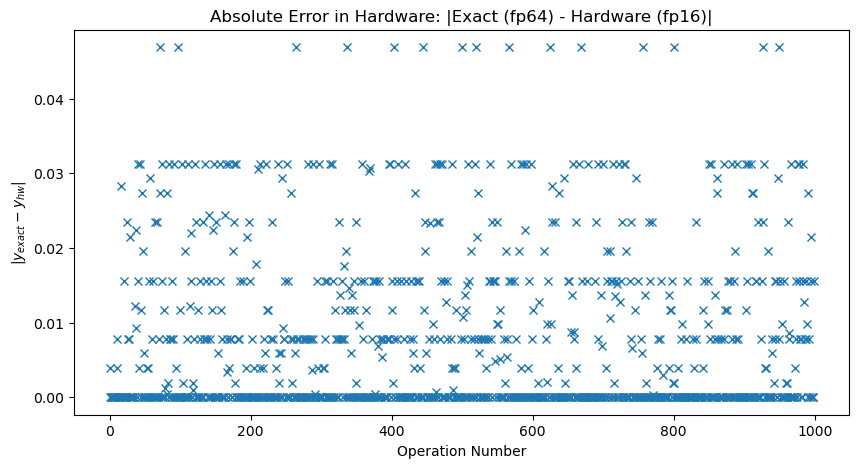

In [124]:
# Plot absolute error
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(error_hw_64, 'x')
plt.title("Absolute Error in Hardware: |Exact (fp64) - Hardware (fp16)|")
# plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Operation Number")
plt.ylabel("$|y_{exact} - y_{hw}|$")

In [125]:
# Number of operations with error
print(f'Number of operations with errors: {np.count_nonzero(error_hw_64)}/{ops}')

# Mean Absolute Error
print(f'Mean Absolute Error (MAE) in Hardware: {np.mean(error_hw_64, dtype=np.float64):.{n_fp}f}')

Number of operations with errors: 492/1000
Mean Absolute Error (MAE) in Hardware: 0.00771255


Text(0, 0.5, '$|y_{sw} - y_{hw}|$')

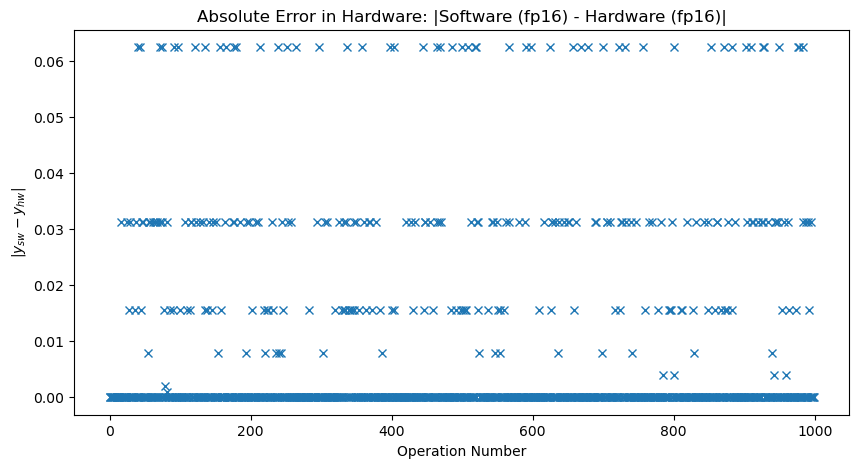

In [126]:
# Plot absolute error
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(error_hw_16, 'x')
plt.title("Absolute Error in Hardware: |Software (fp16) - Hardware (fp16)|")
# plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Operation Number")
plt.ylabel("$|y_{sw} - y_{hw}|$")

In [127]:
# Number of operations with error
print(f'Number of operations with errors: {np.count_nonzero(error_hw_16)}/{ops}')

# Mean Absolute Error
print(f'Mean Absolute Error (MAE) in Hardware: {np.mean(error_hw_16, dtype=np.float64):.{n_fp}f}')

Number of operations with errors: 259/1000
Mean Absolute Error (MAE) in Hardware: 0.00804199


## 3. Reconfigurable Accumulator
- Accumulator with 16 channels.

### 3.1 Test Vectors Generation
- All exceptions were already tested on the fp16 adder.
- Accumulations with normal operations: 2-times 50 accumulations per channel --> 100 operations per channel.
    - Verification for 1st accumulation at operations: 4, 10, 25, 36, 44, 50.
    - Verification for 2nd accumulation at operations: 6, 17, 22, 37, 41, 50.
    - Reset between 1st and 2nd accumulation.
- Text file with 1600 data.
    - 16 consecutive data for the correponding accumulation.  
- For error analysis, we will store the data with different precision:
    - `acc_in_t16` --> correspond to the exact fp16 representation.
    - `acc_in_t64` --> correspond to the exact fp16 representation but extended to fp64 to obtain the exact result.

In [7]:
# Reduced Interval to avoid overflows
low_l = -25
up_l = 30

# List to store accumulator input for all channels 
# 16 consecutive data correspond to one accumulation for 16 channels
acc_in_v = []

In [8]:
# Normal Data for Accumulation
ops = 100
channels = 16
seed = 107

# For reproducibility
np.random.seed(seed=seed)

# Total PRN's for operations
# We need to create a vector and then reshape it
total_d = prng_t(low_l=low_l, up_l=up_l, n_sample=channels*ops)
# Numbers are truncated to fp16
total_d = np.float16(total_d)
# Reshape to a matrix
acc_in = np.reshape(total_d, (channels, ops))

# a for error analysis
# make a shallow copy to get a new array independent of the original
# fp16
acc_in_t16 = np.copy(acc_in)
# fp64
acc_in_t64 = np.copy(acc_in)
acc_in_t64 = np.float64(acc_in_t64)


print(f'Dimension of Test Matrix: {acc_in.shape}')
print(f'Data Type of Test Matrix: {acc_in.dtype}')
print(acc_in[:6, :6])

Dimension of Test Matrix: (16, 100)
Data Type of Test Matrix: float16
[[-16.05    16.52     5.99   -12.61    -6.23   -16.61  ]
 [-22.7      0.595  -24.42    20.27    20.55   -17.22  ]
 [-22.89    13.6    -11.445   -6.434    0.9043  27.23  ]
 [-24.05    15.266   10.62   -13.836   -7.637    2.05  ]
 [  7.004    4.285   15.42   -17.44   -24.86    22.14  ]
 [ -5.445    8.09     2.592   12.95     7.688   24.34  ]]


In [9]:
# For the text file we need the data corresponding to each accumulation in the 16 channels
# Store the data in column-wise
for op in range(ops):
    for channel in range(channels):
        acc_in_v.append(to_FP16_bin(acc_in[channel,op]))

print(f'Dimension of input vector: {len(acc_in_v)}')
print(acc_in_v[0:10])


Dimension of input vector: 1600
['1100110000000011', '1100110110101101', '1100110110111001', '1100111000000011', '0100011100000001', '1100010101110010', '0100100000110110', '1100100001101000', '1100100100011110', '0100100110011100']


### 3.2 Text File Creation
- Create 1 text file:
    - acc_test_vec.txt --> input vectors for 16 channels and up to a 100 accumulations per channel

In [152]:
# Input vector text file
df = pd.DataFrame(acc_in_v)
display(df)

# Save to .txt file
df.to_csv("./test_vectors/acc_test_vec.txt", header=None, index=None, sep=' ', mode='w')

,0
0,1100110000000011
1,1100110110101101
2,1100110110111001
3,1100111000000011
4,0100011100000001
...,...
1595,1100000001010110
1596,0100110011000011
1597,0100110101111111
1598,0100101000111111


### 3.3 Error Analysis
- Compare results from software (sw) and hardware (hw).
    - acc_appx_sw is the result of using fp16 operations.
    - acc_ext_sw is the result of using fp64 operations.
    - acc_appx_hw is the result of using fp16 operations in hardware.

#### 3.3.1 Error in software:

In [10]:
# Emulate the accumulation of 16 channels in software
# Exact result using fp64
print(f'Test Matrix Dimension: {acc_in_t64.shape} ')
print(f'Data is extended to {acc_in_t64.dtype} to get the exact results')
# print(acc_in_t64)

# Matrix to store the accumulation results (Exact results)
acc_ext_sw = np.zeros_like(acc_in_t64)

# Each column of acc_ext_sw is equal to its previous column + the corresponding input data.
# Only the 1st column of acc_ext_sw is equal to the 1st column of input data.
# After the 50th accumulation, there is a reset, and we start accumulating again.
acc_ext_sw[:,0] = acc_in_t64[:,0]

for op in range(ops-1):
    if (op == 49):
        # Reset
        acc_ext_sw[:,op+1] = acc_in_t64[:,op+1]
    else:
        acc_ext_sw[:,op+1] = acc_ext_sw[:,op] + acc_in_t64[:,op+1]

print(f'\nExact Accumulation Matrix has dimension {acc_ext_sw.shape} and type {acc_ext_sw.dtype}')
print(acc_ext_sw)


Test Matrix Dimension: (16, 100) 
Data is extended to float64 to get the exact results

Exact Accumulation Matrix has dimension (16, 100) and type float64
[[-16.046875     0.46875      6.45703125 ... -17.95019531 -18.19274902
   -3.20056152]
 [-22.703125   -22.10791016 -46.52978516 ...  30.75195312  19.73632812
   42.78320312]
 [-22.890625    -9.2890625  -20.734375   ... 166.15612793 195.90612793
  177.15612793]
 ...
 [-18.71875    -12.25        -8.85351562 ... -86.80078125 -94.41015625
  -72.42578125]
 [ 22.421875    43.609375    36.14453125 ... 234.54052734 245.22021484
  257.71240234]
 [-12.3671875   15.1328125   36.6796875  ...  43.06689453  26.45751953
   45.83251953]]


In [11]:
# To verify the operation
print(f'Final accumulation result before reset in Exact Matrix: {acc_ext_sw[:,49]}')
print(f'Accumulate value per channel in interval [0:49]: {np.sum(acc_in_t64[:,:50], axis=1)}')
print(f'\nFinal accumulation result after reset in Exact Matrix: {acc_ext_sw[:,99]}')
print(f'Accumulate value per channel in interval [50:99]: {np.sum(acc_in_t64[:,50:], axis=1)}')

Final accumulation result before reset in Exact Matrix: [222.77441406 204.30395508 298.29418945 130.40672302 211.19091797
 155.20117188 116.85180664 236.44828796 -42.39868164 255.84472656
 190.59057617 284.04527855  99.99517822 135.83410645 189.28173828
 193.9387207 ]
Accumulate value per channel in interval [0:49]: [222.77441406 204.30395508 298.29418945 130.40672302 211.19091797
 155.20117188 116.85180664 236.44828796 -42.39868164 255.84472656
 190.59057617 284.04527855  99.99517822 135.83410645 189.28173828
 193.9387207 ]

Final accumulation result after reset in Exact Matrix: [ -3.20056152  42.78320312 177.15612793 113.43408203 110.5032959
  34.53320312 153.89160156  77.94311523 201.50415039  86.92114258
  10.80078125 -13.21191406  96.96240234 -72.42578125 257.71240234
  45.83251953]
Accumulate value per channel in interval [50:99]: [ -3.20056152  42.78320312 177.15612793 113.43408203 110.5032959
  34.53320312 153.89160156  77.94311523 201.50415039  86.92114258
  10.80078125 -13.21

In [12]:
# Emulate the accumulation of 16 channels in software
# Approx result using fp16
print(f'Test Matrix Dimension: {acc_in_t16.shape} ')
print(f'Data is represented in {acc_in_t16.dtype} to get an approx. result')
# print(acc_in_t16)

# Matrix to store the accumulation results (Approx. results in software)
acc_appx_sw = np.zeros_like(acc_in_t16)

# Each column of acc_appx_sw is equal to its previous column + the corresponding input data.
# Only the 1st column of acc_appx_sw is equal to the 1st column of input data.
# After the 50th accumulation, there is a reset, and we start accumulating again.
acc_appx_sw[:,0] = acc_in_t16[:,0]

for op in range(ops-1):
    if (op == 49):
        # Reset
        acc_appx_sw[:,op+1] = acc_in_t16[:,op+1]
    else:
        acc_appx_sw[:,op+1] = acc_appx_sw[:,op] + acc_in_t16[:,op+1]

acc_appx_sw = np.float64(acc_appx_sw)
print(f'\nApproximate Accumulation Matrix has dimension {acc_appx_sw.shape} and extended to type {acc_appx_sw.dtype} for error calculation')
print(acc_appx_sw)


Test Matrix Dimension: (16, 100) 
Data is represented in float16 to get an approx. result

Approximate Accumulation Matrix has dimension (16, 100) and extended to type float64 for error calculation
[[-16.046875     0.46875      6.45703125 ... -17.9375     -18.1875
   -3.1953125 ]
 [-22.703125   -22.109375   -46.53125    ...  30.625       19.609375
   42.65625   ]
 [-22.890625    -9.2890625  -20.734375   ... 166.125      195.875
  177.125     ]
 ...
 [-18.71875    -12.25        -8.8515625  ... -86.8125     -94.4375
  -72.4375    ]
 [ 22.421875    43.625       36.15625    ... 234.625      245.25
  257.75      ]
 [-12.3671875   15.1328125   36.6875     ...  43.0625      26.453125
   45.8125    ]]


In [13]:
# To verify the operation
print(f'Final accumulation result before reset in Exact Matrix: {acc_appx_sw[:,49]}')
print(f'Accumulate value per channel in interval [0:49]: {np.sum(acc_in_t16[:,:50], axis=1)}')
print(f'\nFinal accumulation result after reset in Exact Matrix: {acc_appx_sw[:,99]}')
print(f'Accumulate value per channel in interval [50:99]: {np.sum(acc_in_t16[:,50:], axis=1)}')

Final accumulation result before reset in Exact Matrix: [222.875  204.5    298.5    130.375  211.25   155.     117.     236.5
 -42.5    255.75   190.375  284.      99.9375 136.     189.25   193.625 ]
Accumulate value per channel in interval [0:49]: [222.8 204.2 298.2 130.4 211.2 155.2 116.9 236.5 -42.4 255.9 190.6 284.
 100.  135.9 189.2 194. ]

Final accumulation result after reset in Exact Matrix: [ -3.1953125  42.65625   177.125     113.4375    110.625      34.40625
 153.875      77.875     201.625      87.125      10.78125   -13.1875
  97.0625    -72.4375    257.75       45.8125   ]
Accumulate value per channel in interval [50:99]: [ -3.201  42.78  177.1   113.44  110.5    34.53  153.9    77.94  201.5
  86.94   10.8   -13.21   96.94  -72.44  257.8    45.84 ]


In [14]:
# Absolute Error calculation
acc_error_sw = np.abs(acc_ext_sw - acc_appx_sw)

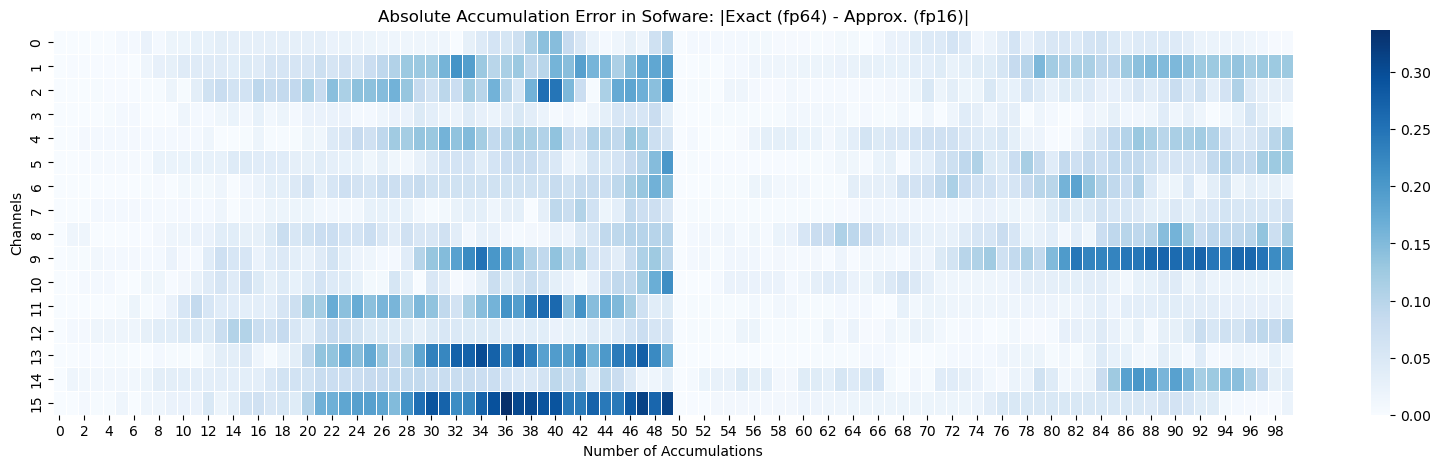

In [15]:
fig = plt.figure(facecolor="w", figsize=(20, 5))
plt.title("Absolute Accumulation Error in Sofware: |Exact (fp64) - Approx. (fp16)|")
ax = sns.heatmap(acc_error_sw, linewidth=0.6, cmap='Blues')
plt.xlabel("Number of Accumulations")
plt.ylabel("Channels")
plt.show()

In [16]:
# Mean Absolute Error per channel
print(f'Mean Absolute Error (MAE) for Accumulation per channel in Sofware:\n {np.mean(acc_error_sw, axis=1, dtype=np.float64)}')

# Mean Absolute Error per accumulation
print(f'\nMean Absolute Error (MAE) per accumulation in Sofware:\n {np.mean(acc_error_sw, axis=0, dtype=np.float64)}')

# Mean Absolute Error
print(f'\nMean Absolute Error (MAE) in Sofware: {np.mean(acc_error_sw, dtype=np.float64):.{n_fp}f}')

Mean Absolute Error (MAE) for Accumulation per channel in Sofware:
 [0.02929443 0.07792969 0.06035645 0.01705978 0.05627075 0.04619141
 0.05002197 0.02502274 0.05006592 0.09149902 0.03320312 0.05858244
 0.0349585  0.06716919 0.05643066 0.09156982]

Mean Absolute Error (MAE) per accumulation in Sofware:
 [0.         0.00271606 0.00421143 0.00494385 0.00494385 0.00621033
 0.00602722 0.01005554 0.01341248 0.01667786 0.01991272 0.02613831
 0.03175354 0.03736877 0.03614807 0.04127502 0.0381012  0.03736877
 0.04595947 0.04162598 0.05638123 0.06541383 0.07554567 0.07304323
 0.07206666 0.07154787 0.07246339 0.07307374 0.07832277 0.08686769
 0.09422243 0.0976404  0.09383714 0.10463274 0.10637224 0.1077379
 0.10554063 0.10456407 0.10764635 0.11162889 0.12371385 0.09130418
 0.0981096  0.08159959 0.09344041 0.10085523 0.11622083 0.12036359
 0.12018049 0.12626588 0.         0.0035553  0.00457764 0.00552368
 0.0085144  0.01037598 0.01239014 0.01116943 0.01040649 0.01031494
 0.01398468 0.01633453 0.0

#### 3.3.2 Error in hardware:
- Use all the accumulation results per channel for comparison.
- 16 consecutive data corresponds to accumulation results for all channels.

In [17]:
# Load the hardware results
df = pd.read_csv("./RTL_results/acc_hw_results.txt", header=None)
display(df)

,0
0,cc03
1,cdad
2,cdb9
3,ce03
4,4701
...,...
1595,cabf
1596,5601
1597,d47d
1598,5bf8


In [18]:
# Get the items in a list
result_l = df[0].astype(str).values.tolist()

print(len(result_l))
print(result_l)

1600
['cc03', 'cdad', 'cdb9', 'ce03', '4701', 'c572', '4836', 'c868', 'c91e', '499c', '4dcb', '4bf5', 'bfe9', 'ccae', '4d9b', 'ca2f', '3780', 'cd86', 'c8a5', 'c864', '49a5', '414c', 'c450', 'cd09', 'd045', '4855', '491e', '49e6', 'cd97', 'ca20', '5173', '4b91', '4675', 'd1d0', 'cd2f', '3f58', '4ead', '453d', 'c2ec', 'd0b7', 'd362', '5031', '4c5d', '4d53', 'c71e', 'c86d', '5084', '5095', 'c627', 'ce8f', 'ceca', 'ca00', '48a2', '4c8c', 'cac6', 'd01f', 'd065', '5065', '5082', '46e8', 'cda2', 'c81f', '4d95', '4f3a', 'ca31', 'c5b0', 'ce90', 'cce8', 'cbcc', '4e78', 'b720', 'cae4', 'd327', '4ff6', '5304', '4f85', '4674', 'c468', '4450', '5046', 'cf3f', 'cdba', '3be0', 'cc64', '468c', '5247', 'c671', '4530', 'cf04', '5202', '519a', '4e10', 'c5b8', 'c296', 'c648', '5052', 'd060', 'ce43', '4b16', 'cfbb', '4ba6', '4e82', '46cd', 'c470', 'ce1b', '54c2', '5249', '51ff', '494c', 'ce19', '47ba', '53ee', 'd336', 'd13f', '49ec', 'cc26', '4eee', '528e', 'ca11', 'ccd7', 'd056', '560d', '5239', '54b9', '5

In [19]:
# Get the fp16 representation of each result
for i, hex_s in enumerate(result_l):
    if (i == 0):
        # In the 1st iteration, we create the array
        # with the fp16 representation
        acc_appx_hw = hex_to_fp16(hex_s=hex_s)
    elif (i == 1):
        # fp16 representation
        acc_result = hex_to_fp16(hex_s=hex_s)
        # Second interation, we concatenate two numbers
        acc_appx_hw = np.concatenate(([acc_appx_hw],[acc_result]), axis=0)

    else:
        # fp16 representation
        acc_result = hex_to_fp16(hex_s=hex_s)
        # For the rest, we just concatenate the results
        acc_appx_hw = np.concatenate((acc_appx_hw,[acc_result]), axis=0)

# Extend to fp64 for error calculation
acc_appx_hw = np.float64(acc_appx_hw)

# Reshape to (number of acc., channel) to place each accumulation result in each row
acc_appx_hw = np.reshape(acc_appx_hw, (ops, channels))

# Transpose the matrix to get the proper dimension
acc_appx_hw = np.transpose(acc_appx_hw)

# Debug
print(f'Accumulation approx. in hardware: dimension {acc_appx_hw.shape} and extended to {acc_appx_hw.dtype}')

Accumulation approx. in hardware: dimension (16, 100) and extended to float64


In [20]:
# Absolute Error calculation
# w.r.t. exact value in sw (fp64)
acc_error_hw_64 = np.abs(acc_ext_sw - acc_appx_hw)
# w.r.t. approx. value in sw (fp16)
acc_error_hw_16 = np.abs(acc_appx_sw - acc_appx_hw)

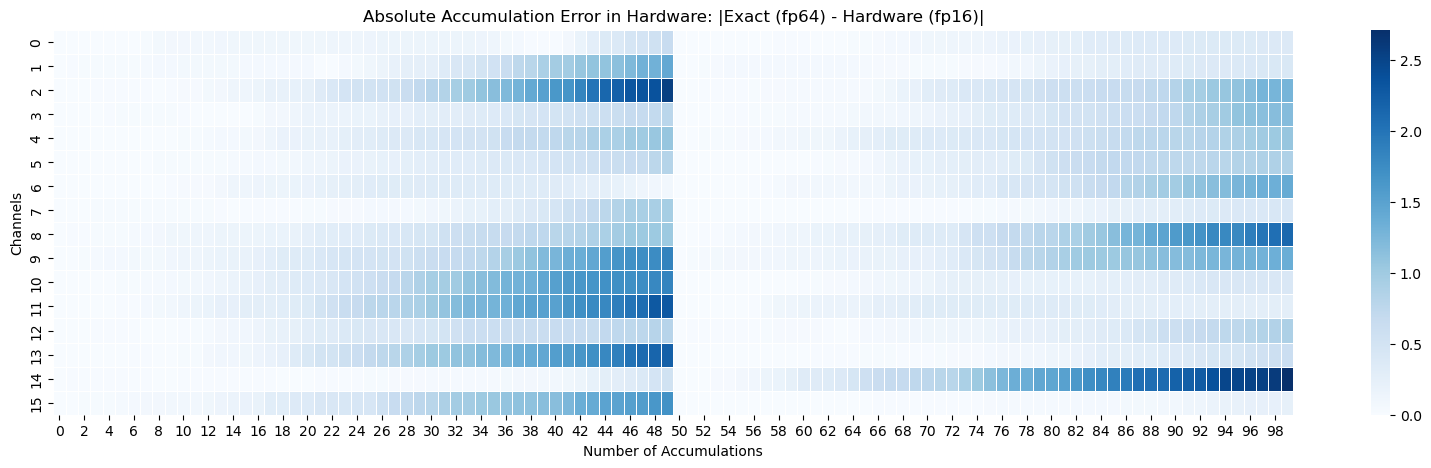

In [21]:
fig = plt.figure(facecolor="w", figsize=(20, 5))
plt.title("Absolute Accumulation Error in Hardware: |Exact (fp64) - Hardware (fp16)|")
ax = sns.heatmap(acc_error_hw_64, linewidth=0.6, cmap='Blues')
plt.xlabel("Number of Accumulations")
plt.ylabel("Channels")
plt.show()

In [22]:
# Mean Absolute Error per channel
print(f'Mean Absolute Error (MAE) for Accumulation per channel in Hardware:\n {np.mean(acc_error_hw_64, axis=1, dtype=np.float64)}')

# Mean Absolute Error per accumulation
print(f'\nMean Absolute Error (MAE) per accumulation in Hardware:\n {np.mean(acc_error_hw_64, axis=0, dtype=np.float64)}')

# Mean Absolute Error
print(f'\nMean Absolute Error (MAE) in Hardware w.r.t. Exact Value: {np.mean(acc_error_hw_64, dtype=np.float64):.{n_fp}f}')

Mean Absolute Error (MAE) for Accumulation per channel in Hardware:
 [0.15827881 0.2740332  0.61210937 0.31896408 0.40989136 0.31033203
 0.33542236 0.17261642 0.59019287 0.62032715 0.46061035 0.52856291
 0.31619873 0.46751831 0.63230957 0.35210693]

Mean Absolute Error (MAE) per accumulation in Hardware:
 [0.         0.00363159 0.0090332  0.01416016 0.01586914 0.02046204
 0.02412415 0.0309906  0.03684998 0.04518127 0.05519104 0.06044006
 0.07484436 0.09046936 0.10389709 0.11366272 0.12709045 0.15711975
 0.17108154 0.19384766 0.21705627 0.24958742 0.26777589 0.3058008
 0.32240236 0.34947145 0.37651002 0.39933717 0.43485963 0.46806276
 0.5005945  0.53684938 0.577968   0.60747087 0.63890398 0.66283739
 0.70605028 0.74889696 0.77288377 0.81498277 0.8551439  0.89930284
 0.94886339 1.00538194 1.06226671 1.0996803  1.15499341 1.1834892
 1.23317182 1.28574121 0.         0.00572205 0.01202393 0.01611328
 0.02008057 0.02352905 0.03030396 0.04165649 0.05169678 0.06311035
 0.07212067 0.07987213 0.

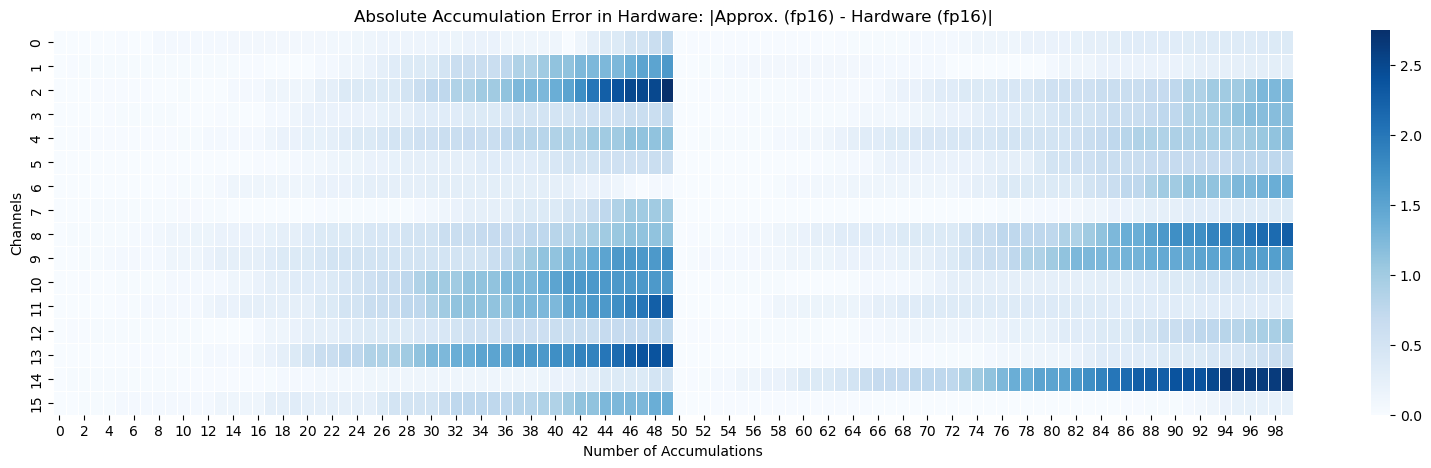

In [23]:
fig = plt.figure(facecolor="w", figsize=(20, 5))
plt.title("Absolute Accumulation Error in Hardware: |Approx. (fp16) - Hardware (fp16)|")
ax = sns.heatmap(acc_error_hw_16, linewidth=0.6, cmap='Blues')
plt.xlabel("Number of Accumulations")
plt.ylabel("Channels")
plt.show()

In [24]:
# Mean Absolute Error per channel
print(f'Mean Absolute Error (MAE) for Accumulation per channel in Hardware:\n {np.mean(acc_error_hw_16, axis=1, dtype=np.float64)}')

# Mean Absolute Error per accumulation
print(f'\nMean Absolute Error (MAE) per accumulation in Hardware:\n {np.mean(acc_error_hw_16, axis=0, dtype=np.float64)}')

# Mean Absolute Error
print(f'\nMean Absolute Error (MAE) in Hardware w.r.t. Approx. Value: {np.mean(acc_error_hw_16, dtype=np.float64):.{n_fp}f}')

Mean Absolute Error (MAE) for Accumulation per channel in Hardware:
 [0.14785156 0.27890625 0.57304687 0.32125    0.4621875  0.26621094
 0.2928125  0.15836426 0.638125   0.65429688 0.44664063 0.48667969
 0.308125   0.52828125 0.6815625  0.26450195]

Mean Absolute Error (MAE) per accumulation in Hardware:
 [0.         0.00634766 0.01293945 0.015625   0.01757812 0.02539062
 0.02734375 0.03076172 0.03515625 0.04296875 0.04638672 0.04638672
 0.05566406 0.07226562 0.08398438 0.08496094 0.09765625 0.13476562
 0.15136719 0.17675781 0.1965332  0.23828125 0.25195312 0.29296875
 0.30566406 0.34082031 0.36328125 0.38378906 0.42480469 0.45996094
 0.49511719 0.53417969 0.58203125 0.60546875 0.62695312 0.63476562
 0.67578125 0.734375   0.74609375 0.77929688 0.82421875 0.875
 0.9296875  0.98828125 1.0625     1.1015625  1.16015625 1.1796875
 1.23046875 1.27734375 0.         0.0078125  0.01611328 0.02001953
 0.02539062 0.03027344 0.03417969 0.04394531 0.05371094 0.06152344
 0.07620239 0.08569336 0.0856

# Test

- Variation of normal numbers from full precision (FP32) to half precision (FP16)

In [6]:
# Reduced Interval to avoid overflows
low_l = -50
up_l = 50

np.random.seed(seed=124)

# Generate a random number
aux1 = prng_t(low_l=low_l, up_l=up_l)
print(f'Original number: {aux1} --> Type {type(aux1)}')

# Conver to float32
aux1 = np.float32(aux1)
print(f'FP32 number: {aux1} --> Type {aux1.dtype}')

# Conver to float16 (half precision)
aux1 = np.float16(aux1)
print(f'FP16 number: {aux1} --> Type {aux1.dtype}')

# Back to float32 (Single precision)
aux1 = np.float32(aux1)
print(f'Back to FP32 number: {aux1} --> Type {aux1.dtype}')

# Back to float64 (double precision)
aux1 = np.float64(aux1)
print(f'To FP64 number: {aux1} --> Type {aux1.dtype}')

Original number: -39.393509404526725 --> Type <class 'float'>
FP32 number: -39.39350891113281 --> Type float32
FP16 number: -39.40625 --> Type float16
Back to FP32 number: -39.40625 --> Type float32
To FP64 number: -39.40625 --> Type float64


- Normal Numbers range in Python

In [164]:
# For Python this is the maximum FP16 
to_FP16_bin(65519)

'0111101111111111'

In [167]:
# For Python this is the minimum FP16
to_FP16_bin(-65519)

'1111101111111111'

- Subnormal Numbers range in Python

In [179]:
# Largest subnormal number
# to_FP16_bin(0.00006097555160522461)
to_FP16_bin(0.000061)

'0000001111111111'

In [125]:
a =  np.inf
b = -np.inf
print(to_FP16_bin(a+b))

1111111000000000


In [34]:
a = to_FP16_bin(np.inf)
print(a)

0111110000000000


In [35]:
a = to_FP16_bin(-np.inf)
print(a)

1111110000000000


In [32]:
a = to_FP16_bin(np.nan)
print(a)

0111111000000000


In [31]:
aux1 = np.nan + 1.
print(aux1)
print(to_FP16_bin(aux1))

nan
0111111000000000


In [29]:
np.random.seed(191)
low_l = -5
up_l = 5

aux2 = (up_l - low_l) * np.random.random_sample() + low_l
print(aux2)

0.4160974819907892


In [110]:
aux3 = (up_l - low_l) * np.random.random_sample() + low_l
print(aux3)

21331.735292663914


- Hex data to fp16

In [136]:
# Simulate of the results from testbench
hex_string = '4cec'
# hex_string = '3fe0'
# hex_string = 'd0c1'

# Hex string --> INT16 --> INT16 to binary string
aux1 = bin(int(hex_string, 16))
# Drop the '0b'
aux1 = aux1[2:].zfill(16)

print(aux1)
print(type(aux1))
print(len(aux1))

0100110011101100
<class 'str'>
16


In [137]:
# Separate sign, exponent, and mantissa.
# Get their numerical representation
# Turn the number into fp16 to make sure that the reconstructed number will be fp16

sign_t = aux1[0]
print(f'Sign in bits: {sign_t}')
sign_t = int(sign_t, 2)
sign_t = np.float16(sign_t)
print(f'Sign value is {sign_t} and type is {sign_t.dtype}\n')

exp_t = aux1[1:6]
print(f'Exponent in bits: {exp_t}')
exp_t = int(exp_t, 2)
exp_t = np.float16(exp_t)
print(f'Exponent value is {exp_t} and type is {exp_t.dtype}\n')

man_t = aux1[6:]
print(f'Mantissa in bits: {man_t}')
man_t = int(man_t, 2)
man_t = np.float16(man_t)
print(f'Mantissa value is {man_t} and type is {man_t.dtype}\n')

Sign in bits: 0
Sign value is 0.0 and type is float16

Exponent in bits: 10011
Exponent value is 19.0 and type is float16

Mantissa in bits: 0011101100
Mantissa value is 236.0 and type is float16



In [138]:
# Apply the formula to calculate fp6 number
number_t = ((np.float16(-1))**sign_t) * (np.float16(2)**(exp_t - np.float16(15))) * (np.float16(1) + (man_t/np.float16(1024)))
print(f'fp16 Decimal number: {number_t}')
print(f'and type is {number_t.dtype}')

fp16 Decimal number: 19.6875
and type is float16


In [139]:
aux2 = np.concatenate(([number_t],[number_t]), axis=0)
print(aux2.shape)
print(aux2)
print(aux2.dtype)
print(f'{aux2[0]}')

(2,)
[19.69 19.69]
float16
19.6875


In [143]:
aux3 = np.concatenate((aux2, [1.13]), axis=0)
print(aux3.shape)
print(aux3)
print(aux3.dtype)

(3,)
[19.6875 19.6875  1.13  ]
float64


In [144]:
aux4 = np.concatenate((aux3, [-22.94]), axis=0)
print(aux4.shape)
print(aux4)
print(aux4.dtype)

(4,)
[ 19.6875  19.6875   1.13   -22.94  ]
float64


In [145]:
aux5 = np.reshape(aux4, (2,2))
print(aux5.shape)
print(aux5)
print(aux5.dtype)

(2, 2)
[[ 19.6875  19.6875]
 [  1.13   -22.94  ]]
float64


In [146]:
aux6 = np.transpose(aux5)
print(aux6.shape)
print(aux6)
print(aux6.dtype)

(2, 2)
[[ 19.6875   1.13  ]
 [ 19.6875 -22.94  ]]
float64


In [ ]:
idx = np.where(np.isinf(y_approx_hw))
print(idx)
print(result_l[892])

- Array of objects

In [18]:
aux1 = np.empty((2,2), dtype=object)
print(aux1)

aux1[0,0] = 'Pri'
aux1[1,1] = 'Pul'
print(aux1)

[[None None]
 [None None]]
[['Pri' None]
 [None 'Pul']]
